In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import kagglehub
import pathlib
import pickle
import pandas as pd

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.16.2


/Users/alvarocastillejo/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
path = kagglehub.dataset_download("harbhajansingh21/german-traffic-sign-dataset")

print("Path to dataset files:", path)

data_dir = pathlib.Path(path)

train_dir = data_dir / "train.p"
test_dir  = data_dir / "test.p"

Path to dataset files: /Users/alvarocastillejo/.cache/kagglehub/datasets/harbhajansingh21/german-traffic-sign-dataset/versions/1


In [3]:
def load_data(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    return data['features'], data['labels']

In [4]:
train_images, train_labels = load_data(os.path.join(path, "train.p"))
valid_images, valid_labels = load_data(os.path.join(path, "valid.p"))
test_images, test_labels   = load_data(os.path.join(path, "test.p"))

sign_df = pd.read_csv(os.path.join(path, "signname.csv"))
class_names = sign_df["SignName"].tolist()

print(train_images.shape)  # e.g. (34799, 32, 32, 3)

(34799, 32, 32, 3)


In [5]:
# Update your constants
NUM_CLASSES = 43  
CLASSES = 43      
INPUT_SIZE = 96   # Changed from 96
CANVAS = 96       # Changed from 96
OBJ_SIZE = 72     # Changed from 48
BATCH_SIZE = 96   
INPUT_SHAPE = (96, 96, 3) # Changed from 96, 96, 3

def transform(image, label):
    image = tf.cast(image, tf.float32)
    
    # Stronger Augmentation to fight overfitting
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_hue(image, max_delta=0.08) 
    image = tf.image.random_saturation(image, lower=0.6, upper=1.4)
    
    # Resize the sign to the defined object size
    image = tf.image.resize(image, (OBJ_SIZE, OBJ_SIZE))

    # Randomly place the sign on the canvas
    xmin = tf.random.uniform((), 0, CANVAS - OBJ_SIZE, dtype=tf.int32)
    ymin = tf.random.uniform((), 0, CANVAS - OBJ_SIZE, dtype=tf.int32)

    image = tf.image.pad_to_bounding_box(image, ymin, xmin, CANVAS, CANVAS)

    # Normalize Bbox coordinates
    xmin_f = tf.cast(xmin, tf.float32) / CANVAS
    ymin_f = tf.cast(ymin, tf.float32) / CANVAS
    xmax_f = tf.cast(xmin + OBJ_SIZE, tf.float32) / CANVAS
    ymax_f = tf.cast(ymin + OBJ_SIZE, tf.float32) / CANVAS
    bbox = tf.stack([xmin_f, ymin_f, xmax_f, ymax_f])

    return image, (tf.one_hot(label, NUM_CLASSES), bbox)

def transform_val(image, label):
    # Standardize validation to match training scale (0-255)
    image = tf.cast(image, tf.float32) 
    image = tf.image.resize(image, (OBJ_SIZE, OBJ_SIZE))

    # Center the sign on the canvas for validation consistency
    xmin = (CANVAS - OBJ_SIZE) // 2
    ymin = (CANVAS - OBJ_SIZE) // 2

    image = tf.image.pad_to_bounding_box(image, ymin, xmin, CANVAS, CANVAS)

    # Bbox coordinates
    xmin_f = xmin / CANVAS
    ymin_f = ymin / CANVAS
    xmax_f = (xmin + OBJ_SIZE) / CANVAS
    ymax_f = (ymin + OBJ_SIZE) / CANVAS
    bbox = tf.stack([xmin_f, ymin_f, xmax_f, ymax_f])

    return image, (tf.one_hot(label, NUM_CLASSES), bbox)



In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(5000)
train_ds = train_ds.map(transform, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

2026-02-19 20:45:44.522043: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2026-02-19 20:45:44.522764: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2026-02-19 20:45:44.522824: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2026-02-19 20:45:44.524142: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-19 20:45:44.524317: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
valid_ds = valid_ds.map(transform_val, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(256)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

# Visualization Utilities

These functions are used to draw bounding boxes around the digits.

In [8]:
im_width = 96
im_height = 96
use_normalized_coordinates = True
iou_threshold = 0.5


def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color=('red',),
                                       thickness=2,
                                       display_str_list=()):
    """
    image: numpy array (96,96,3)
    boxes: [N,4] in format [xmin, ymin, xmax, ymax] normalized
    """

    image_pil = PIL.Image.fromarray(image.astype(np.uint8)).convert("RGB")
    draw = PIL.ImageDraw.Draw(image_pil)

    im_width, im_height = image_pil.size

    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box

        left   = xmin * im_width
        right  = xmax * im_width
        top    = ymin * im_height
        bottom = ymax * im_height

        draw.rectangle(
            [(left, top), (right, bottom)],
            outline=color[i % len(color)],
            width=thickness
        )

        if display_str_list:
            draw.text((left, top - 10),
                      display_str_list[i],
                      fill=color[i % len(color)])

    return np.array(image_pil)


def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color = [],
                                 thickness = 1,
                                 display_str_list = ()):
  """Draws bounding boxes on image.
  Args:
    image: a PIL.Image object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: a list of strings for each bounding box.

  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                               boxes[i, 2], color[i], thickness, display_str_list[i])

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color = 'red',
                               thickness = 1,
                               display_str = None,
                               use_normalized_coordinates = True):
  """Adds a bounding box to an image.
  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.
  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: string to display in box
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = PIL.ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width = thickness, fill = color)

These utilities are used to visualize the data and predictions.

In [9]:
"""
This cell contains helper functions used for visualization
and downloads only.

You can skip reading it, as there is very
little Keras or Tensorflow related code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):

    batch_train_ds = training_dataset.unbatch().batch(N)

    for val_imgs, (val_labels, val_boxes) in validation_dataset.take(1):
        validation_images = val_imgs.numpy()
        validation_labels = np.argmax(val_labels.numpy(), axis=1)
        validation_boxes  = val_boxes.numpy()

    for train_imgs, (train_labels, train_boxes) in batch_train_ds.take(1):
        training_images = train_imgs.numpy()
        training_labels = np.argmax(train_labels.numpy(), axis=1)
        training_boxes  = train_boxes.numpy()

    return (training_images, training_labels, training_boxes,
            validation_images, validation_labels, validation_boxes)


# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (96*n, 96), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*96,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [96, 96*n]), n, axis=1), axis=0), [n, 96*96])
  return font_digits, font_labels


# utility to display a row of digits with their predictions
def display_digits_with_boxes(images,
                              predictions,
                              labels,
                              pred_bboxes,
                              true_bboxes,
                              iou,
                              title):

    n = 10
    indexes = np.random.choice(len(images), size=n)

    plt.figure(figsize=(20,4))
    plt.suptitle(title)

    for i, idx in enumerate(indexes):

        ax = plt.subplot(1, n, i+1)

        # convert to uint8 for drawing
        img = images[idx].astype(np.uint8)

        boxes = []
        colors = []
        names = []

        if len(true_bboxes):
            boxes.append(true_bboxes[idx])
            colors.append('green')
            names.append("true")

        if len(pred_bboxes):
            boxes.append(pred_bboxes[idx])
            colors.append('red')
            names.append("pred")

        if boxes:
            img = draw_bounding_boxes_on_image_array(
                img,
                np.array(boxes),
                color=colors,
                display_str_list=names
            )

        plt.imshow(img)
        plt.axis("off")

        pred_class = predictions[idx]
        true_class = labels[idx]

        title_color = "red" if pred_class != true_class else "black"
        ax.set_title(class_names[pred_class], color=title_color, fontsize=9)

    plt.show()


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=None, smooth=False):
    plt.figure(figsize=(6,4))

    train = history.history[metric_name]
    val   = history.history.get('val_' + metric_name)

    # optional smoothing (helps noisy validation curves)
    if smooth:
        import numpy as np
        def smooth_curve(data, weight=0.6):
            smoothed = []
            last = data[0]
            for point in data:
                last = last * weight + (1 - weight) * point
                smoothed.append(last)
            return smoothed
        train = smooth_curve(train)
        if val:
            val = smooth_curve(val)

    plt.plot(train, label="Train", linewidth=2)

    if val:
        plt.plot(val, label="Validation", linewidth=2)

    plt.title(title, fontsize=14)
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)

    if ylim:
        plt.ylim(0, ylim)

    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Visualize Data

2026-02-19 20:45:45.613031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-19 20:45:45.721608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


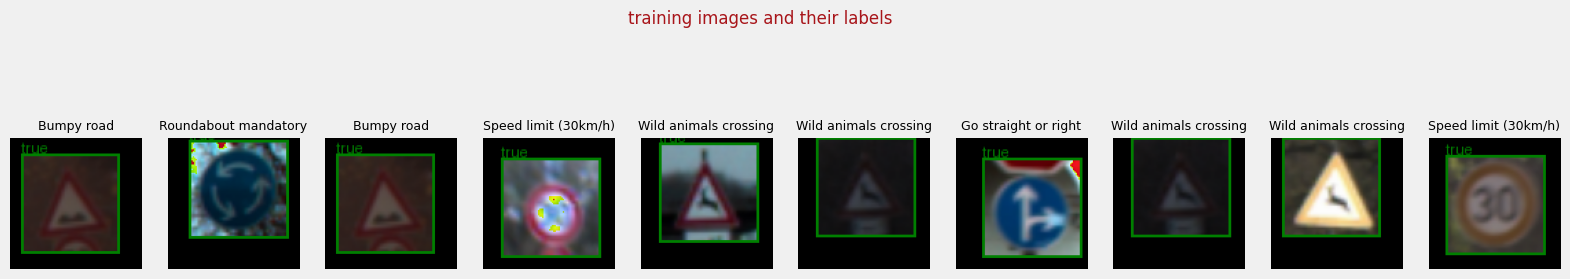

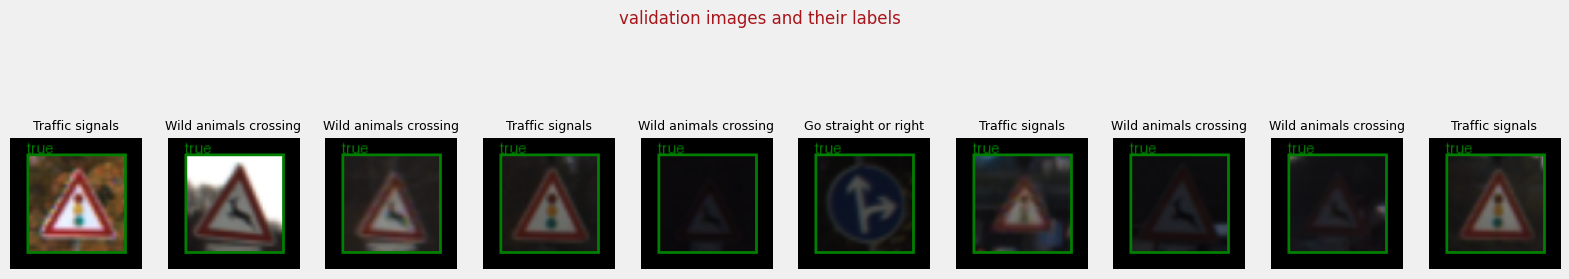

In [10]:
(training_digits, training_labels, training_bboxes,
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(train_ds, valid_ds, 10)

display_digits_with_boxes(
    training_digits,
    training_labels,
    training_labels,
    np.array([]),
    training_bboxes,
    np.array([]),
    "training images and their labels"
)

display_digits_with_boxes(
    validation_digits,
    validation_labels,
    validation_labels,
    np.array([]),
    validation_bboxes,
    np.array([]),
    "validation images and their labels"
)

In [11]:
import tensorflow as tf

# 1. Update Constants (keep these)
CLASSES = 43
INPUT_SIZE = 96
INPUT_SHAPE = (INPUT_SIZE, INPUT_SIZE, 3)

def build_transfer_learning_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False 

    inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    
    features = base_model(x, training=False)
    shared = tf.keras.layers.GlobalAveragePooling2D()(features)
    
    # Classification Head - Increased Dropout to 0.4
    class_branch = tf.keras.layers.Dense(256, activation='relu')(shared)
    class_branch = tf.keras.layers.BatchNormalization()(class_branch)
    class_branch = tf.keras.layers.Dropout(0.4)(class_branch) 
    class_out = tf.keras.layers.Dense(CLASSES, activation='softmax', name='classifier_head')(class_branch)
    
    # Regression Head
    reg_branch = tf.keras.layers.Dense(128, activation='relu')(shared)
    bbox_out = tf.keras.layers.Dense(4, activation='sigmoid', name='regressor_head')(reg_branch)

    return tf.keras.Model(inputs=inputs, outputs=[class_out, bbox_out])


# 3. BUILD AND COMPILE
model = build_transfer_learning_model()

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 96, 96, 3) │          0 │ input_layer_1[0]… │
│ (TrueDivide)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 96, 96, 3) │          0 │ true_divide[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_96 │ (None, 3, 3,      │  2,257,984 │ subtract[0][0]    │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    327,936 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │    163,968 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_head     │ (None, 43)        │     11,051 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regressor_head      │ (None, 4)         │        516 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,762,479 (10.54 MB)

 Trainable params: 503,983 (1.92 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [12]:
# IMPORTANT: Use a lower learning rate to prevent the loss spikes you saw
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # Faster start
    loss={"classifier_head": "categorical_crossentropy", "regressor_head": "mse"},
    loss_weights={"classifier_head": 10.0, "regressor_head": 1.0},
    metrics={"classifier_head": "accuracy", "regressor_head": "mse"}
)

In [13]:
# Place this before your first training cell
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_classifier_head_loss', # We monitor the head you want to improve
    factor=0.2,                         # Drop LR by 5x when it plateaus
    patience=3,                         # Wait 3 epochs before droppi
    mode='min',
    verbose=1
)

# In your existing frozen training cell:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[lr_scheduler] # Add it here
)

Epoch 1/10


2026-02-19 20:45:49.584961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


362/362 ━━━━━━━━━━━━━━━━━━━━ 66s 171ms/step - classifier_head_accuracy: 0.6259 - classifier_head_loss: 1.4548 - loss: 14.5644 - regressor_head_loss: 0.0165 - regressor_head_mse: 0.0165 - val_classifier_head_accuracy: 0.3578 - val_classifier_head_loss: 3.0657 - val_loss: 31.9873 - val_regressor_head_loss: 0.0088 - val_regressor_head_mse: 0.0089 - learning_rate: 0.0010
Epoch 2/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 60s 166ms/step - classifier_head_accuracy: 0.6915 - classifier_head_loss: 1.1016 - loss: 11.0281 - regressor_head_loss: 0.0125 - regressor_head_mse: 0.0125 - val_classifier_head_accuracy: 0.3923 - val_classifier_head_loss: 2.7503 - val_loss: 28.6547 - val_regressor_head_loss: 0.0087 - val_regressor_head_mse: 0.0087 - learning_rate: 0.0010
Epoch 3/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 74s 204ms/step - classifier_head_accuracy: 0.7247 - classifier_head_loss: 0.9290 - loss: 9.3023 - regressor_head_loss: 0.0123 - regressor_head_mse: 0.0123 - val_classifier_head_accuracy: 0.3984 - val_classifie

In [14]:
# 1. Dynamically find the base_model
base_model_layer = next(l for l in model.layers if 'mobilenetv2' in l.name)
base_model_layer.trainable = True

# 2. Unfreeze from layer 80 (Deeper than before)
for layer in base_model_layer.layers[:80]: 
    layer.trainable = False

# 3. Re-compile with an even lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6), 
    loss={"classifier_head": "categorical_crossentropy", "regressor_head": "mse"},
    loss_weights={"classifier_head": 10.0, "regressor_head": 1.0},
    metrics={"classifier_head": "accuracy", "regressor_head": "mse"}
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_classifier_head_accuracy', 
    patience=5, 
    restore_best_weights=True,
    mode='max'
)


# 4. Train with the same early stopping and scheduler logic
history_finetune = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=20,
    callbacks=[early_stop, lr_scheduler]
)


Epoch 1/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 147s 367ms/step - classifier_head_accuracy: 0.3550 - classifier_head_loss: 2.8572 - loss: 28.5861 - regressor_head_loss: 0.0140 - regressor_head_mse: 0.0140 - val_classifier_head_accuracy: 0.4628 - val_classifier_head_loss: 2.8231 - val_loss: 29.2846 - val_regressor_head_loss: 0.0057 - val_regressor_head_mse: 0.0057 - learning_rate: 5.0000e-06
Epoch 2/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 117s 323ms/step - classifier_head_accuracy: 0.4583 - classifier_head_loss: 2.0621 - loss: 20.6340 - regressor_head_loss: 0.0134 - regressor_head_mse: 0.0134 - val_classifier_head_accuracy: 0.4925 - val_classifier_head_loss: 2.3390 - val_loss: 24.1465 - val_regressor_head_loss: 0.0063 - val_regressor_head_mse: 0.0063 - learning_rate: 5.0000e-06
Epoch 3/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 128s 355ms/step - classifier_head_accuracy: 0.5274 - classifier_head_loss: 1.6812 - loss: 16.8248 - regressor_head_loss: 0.0128 - regressor_head_mse: 0.0128 - val_classifier_head_accuracy:

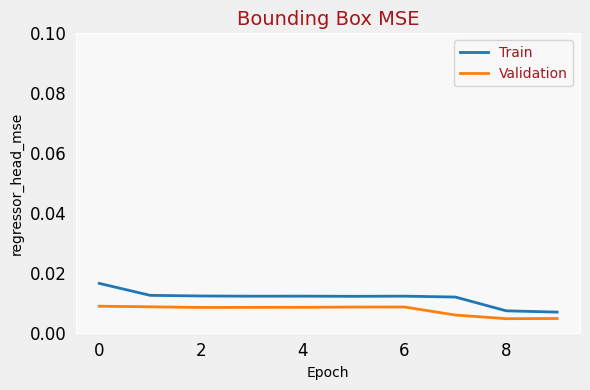

In [15]:
plot_metrics("regressor_head_mse", "Bounding Box MSE", ylim=0.1)


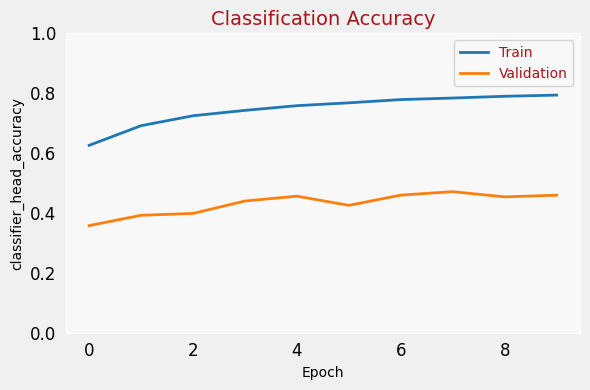

In [16]:
plot_metrics("classifier_head_accuracy",
             "Classification Accuracy",
             ylim=1)

## Intersection over union

Calculate the I-O-U metric to evaluate the model's performance.

In [17]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

### Visualize predictions
The following code will make predictions and visualize both the classification and the predicted bounding boxes.
- The true bounding box labels will be in green, and the model's predicted bounding boxes are in red.
- The predicted number is shown below the image.

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step 
Number of predictions where iou > threshold(0.4): 256
Number of predictions where iou < threshold(0.4): 0


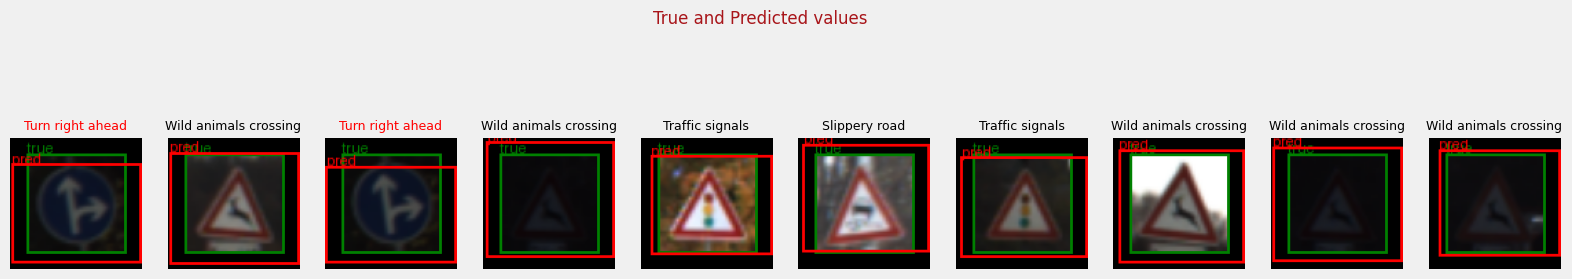

In [18]:
# recognize validation digits
predictions = model.predict(validation_digits, batch_size=96)
predicted_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)

iou_threshold = 0.4

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")

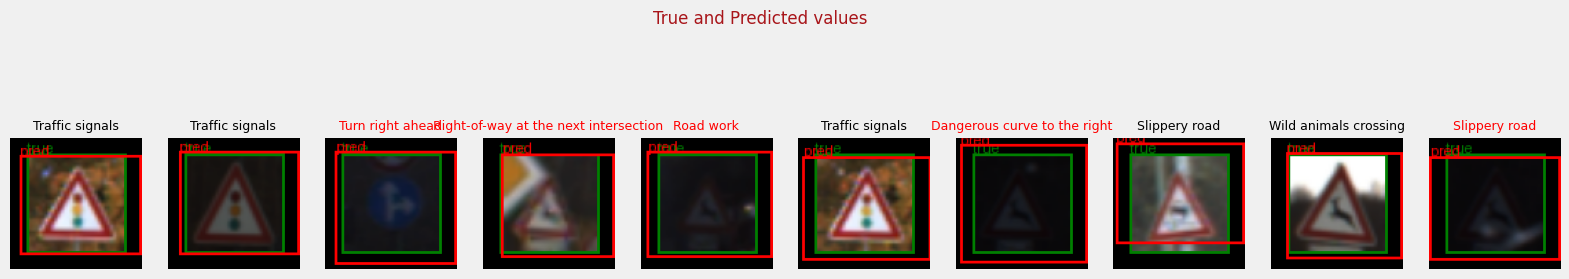

In [19]:
display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")

In [20]:
# Save the entire model (architecture, weights, and optimizer state)
model.save('traffic_sign_model_final.keras')

# Also save just the weights as a backup
model.save_weights('traffic_sign_weights_final.weights.h5')

print("Model saved successfully as 'traffic_sign_model_final.keras'")

Model saved successfully as 'traffic_sign_model_final.keras'
